In [14]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [15]:
league_id = 84057
# I am team 10

In [16]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%('docker','docker',dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [17]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "kona_player_info"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()
data.keys()

dict_keys(['players'])

In [27]:
stat_list = []
team_id_list = []
injured_list = []
injuryStatus_list = []
for player in data['players']:
    #print(player['player']['fullName'])
    for stat_item in player['player']['stats']:
        #looks like season totals AND averages id = '002020'
        if stat_item['id'] == '002020':
            if '40' in stat_item['stats'].keys(): # '40' is minutes
                stat_item['stats']['playerName'] = player['player']['fullName']
                stat_list.append(stat_item['stats'])
                team_id_list.append(player['onTeamId'])
                injured_list.append(player['player']['injured'])
                injuryStatus_list.append(player['player']['injuryStatus'])

In [28]:
stats_df = pd.DataFrame(stat_list)
stats_df['onTeamId'] = team_id_list
stats_df['injured'] = injured_list
stats_df['injuryStatus'] = injuryStatus_list
stats_df.shape

(461, 48)

In [35]:
stats_df.injuryStatus.value_counts()

ACTIVE        380
OUT            51
DAY_TO_DAY     30
Name: injuryStatus, dtype: int64

In [7]:
col_rename_dict = {'0':'pts', '1':'blocks', '2':'steals', '3':'ast', '6':'reb', '13':'fgm', '14': 'fga', 
                   '15': 'ftm', '16':'fta', '17':'threes', '40':'min', '42':'gp'}
stats_df.rename(columns=col_rename_dict, inplace=True)
stats_df['fg_pct'] = stats_df['fgm'] / stats_df['fga']
stats_df['ft_pct'] = stats_df['ftm'] / stats_df['fta']
stats_df = stats_df[['playerName','onTeamId','pts','blocks','steals','ast','reb','fgm','fga','fg_pct','ftm','fta','ft_pct','threes','min','gp']]

In [8]:
stats_df.head()

,playerName,onTeamId,pts,blocks,steals,ast,reb,fgm,fga,fg_pct,ftm,fta,ft_pct,threes,min,gp
0,Vince Carter,0,158.0,13.0,12.0,32.0,62.0,57.0,173.0,0.329480,12.0,17.0,0.705882,32.0,508.0,33.0
1,Tyson Chandler,0,34.0,8.0,6.0,6.0,63.0,14.0,18.0,0.777778,6.0,13.0,0.461538,0.0,209.0,23.0
2,LeBron James,6,939.0,20.0,48.0,397.0,296.0,359.0,735.0,0.488435,141.0,204.0,0.691176,80.0,1292.0,37.0
3,Carmelo Anthony,12,406.0,15.0,26.0,29.0,152.0,153.0,356.0,0.429775,60.0,73.0,0.821918,40.0,791.0,25.0
4,Kyle Korver,0,213.0,7.0,16.0,43.0,64.0,68.0,170.0,0.400000,21.0,24.0,0.875000,56.0,574.0,35.0


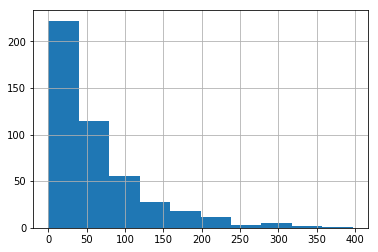

In [9]:
stats_df['ast'].hist()

In [10]:
stats_df.loc[:,'ast_rank'] = stats_df.apply(lambda x: ( (x['ast'] - stats_df['ast'].mean()) / stats_df['ast'].std()) , axis = 1)
stats_df.loc[:,'blocks_rank'] = stats_df.apply(lambda x: ( (x['blocks'] - stats_df['blocks'].mean()) / stats_df['blocks'].std()) , axis = 1)
stats_df.loc[:,'steals_rank'] = stats_df.apply(lambda x: ( (x['steals'] - stats_df['steals'].mean()) / stats_df['steals'].std()) , axis = 1)
stats_df.loc[:,'reb_rank'] = stats_df.apply(lambda x: ( (x['reb'] - stats_df['reb'].mean()) / stats_df['reb'].std()) , axis = 1)
stats_df.loc[:,'pts_rank'] = stats_df.apply(lambda x: ( (x['pts'] - stats_df['pts'].mean()) / stats_df['pts'].std()) , axis = 1)
stats_df.loc[:,'threes_rank'] = stats_df.apply(lambda x: ( (x['threes'] - stats_df['threes'].mean()) / stats_df['threes'].std()) , axis = 1)
stats_df.loc[:,'fta_rank'] = stats_df.apply(lambda x: ( (x['fta'] - stats_df['fta'].mean()) / stats_df['fta'].std()) , axis = 1)
stats_df.loc[:,'fga_rank'] = stats_df.apply(lambda x: ( (x['fga'] - stats_df['fga'].mean()) / stats_df['fga'].std()) , axis = 1)
stats_df.loc[:,'ft_pct_rank'] = stats_df.apply(lambda x: ( (x['ft_pct'] - stats_df['ft_pct'].mean()) / stats_df['ft_pct'].std()) , axis = 1)
stats_df.loc[:,'fg_pct_rank'] = stats_df.apply(lambda x: ( (x['fg_pct'] - stats_df['fg_pct'].mean()) / stats_df['fg_pct'].std()) , axis = 1)
stats_df['fg_rank_adj'] = stats_df['fg_pct_rank'] * stats_df['fga_rank']
stats_df['ft_rank_adj'] = stats_df['ft_pct_rank'] * stats_df['fta_rank']

cat_ranks = ['ast_rank','blocks_rank','steals_rank','reb_rank','pts_rank','threes_rank','fg_rank_adj','ft_rank_adj']
stats_df['total_rank'] = stats_df[cat_ranks].sum(axis=1)
stats_df.sort_values('total_rank', inplace=True, ascending= False)

final_stats_df = stats_df[['playerName','onTeamId','total_rank'] + cat_ranks]

In [11]:
# how to properly account for fga and fta in their ranks? Did what I did make sense? doesn't appear to match up well with website
# do I need to remove anyone when I calculate the ranks?

In [12]:
my_team = final_stats_df.loc[final_stats_df.onTeamId==10]
my_team = my_team.loc[my_team.playerName != 'Jonathan Isaac'] # how to remove players on IR
my_team

,playerName,onTeamId,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
221,Giannis Antetokounmpo,10,12.088288,2.290000,1.792465,1.656283,3.792098,3.481757,1.036774,2.440489,-4.401578
264,Nikola Jokic,10,11.329684,2.875339,0.472244,1.093057,2.742833,1.926414,0.750594,0.947193,0.522010
193,Buddy Hield,10,7.634867,0.919074,-0.055845,0.717573,0.858230,2.081948,3.548800,-0.725783,0.290870
119,Tomas Satoransky,10,5.624884,2.305404,-0.451911,2.282089,0.328504,0.489767,0.496211,-0.004098,0.178918
391,Miles Bridges,10,5.326019,0.287524,1.264377,0.467251,1.194403,0.989114,1.036774,0.030774,0.055802
252,Julius Randle,10,5.213295,0.965285,-0.253878,0.592412,2.325164,1.750414,0.464413,0.012157,-0.642673
190,Taurean Prince,10,4.901956,0.302928,0.274211,0.905315,1.398144,0.763999,2.054303,-0.723329,-0.073614
46,Derrick Rose,10,4.675473,2.074349,-0.121856,0.592412,-0.374401,1.324741,0.114638,0.503709,0.561881
430,PJ Washington,10,4.439436,0.164295,1.330388,0.905315,0.848043,0.686232,0.623402,0.156838,-0.275077
397,Markelle Fultz,10,3.514962,1.704661,-0.385900,1.906605,0.043267,0.612557,-0.425925,0.052066,0.007630


In [13]:
my_team[cat_ranks].sum()

ast_rank       12.302247
blocks_rank    11.618091
steals_rank    11.643935
reb_rank       14.406661
pts_rank       13.390578
threes_rank     6.864116
fg_rank_adj     0.350989
ft_rank_adj    -2.872393
dtype: float64